In [ ]:
# preprocess_nlp.py
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Load spaCy model (assume en_core_web_sm downloaded)
nlp = spacy.load('en_core_web_sm')

# Load cleaned data
df = pd.read_csv(r'C:\Users\hp\Pictures\fintech-review-analytics\fintech-review-analytics-week2\Data\cleaned_reviews.csv')

# Preprocessing function
def preprocess_text(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]
    return ' '.join(tokens)
# Fix NaN / floats
df["review"] = df["review"].fillna("").astype(str)
# Apply preprocessing
df['processed_review'] = df['review'].apply(preprocess_text)

# Save preprocessed data
df.to_csv(r'C:\Users\hp\Pictures\fintech-review-analytics\fintech-review-analytics-week2\Data/preprocessed_reviews.csv', index=False)
print(f"Preprocessed {len(df)} reviews.")

In [ ]:
import pandas as pd
import pytest

def test_preprocessing():
    df = pd.read_csv(r'C:\Users\hp\Pictures\fintech-review-analytics\fintech-review-analytics-week2\Data\preprocessed_reviews.csv')
    assert 'processed_review' in df.columns
    assert df['processed_review'].notnull().all()  # No empty after preprocess

In [ ]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["USE_TF"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "4"  # stop TF logs

import torch
from transformers import pipeline
import pandas as pd


In [22]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"

# sentiment analysis 
import pandas as pd
from transformers import pipeline
import torch as torch

 # <-- FIXED

# Load preprocessed data
df = pd.read_csv(r'C:\Users\hp\Pictures\fintech-review-analytics\fintech-review-analytics-week2\Data\preprocessed_reviews.csv')

import re

def remove_amharic(text):
    if pd.isna(text):
        return text
    # Ethiopic script ranges: \u1200–\u137F
    return re.sub(r'[\u1200-\u137F]+', '', text)

df['preprocessed_reviews'] = df['review'].apply(remove_amharic)

# Initialize DistilBERT sentiment pipeline
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    framework="pt"   # <--- Forces PyTorch
)

# Function to get sentiment
def get_sentiment(text):
    if not text.strip():  # Skip empty
        return 'neutral', 0.0
    result = sentiment_pipeline(text)[0]
    label = result['label'].lower()
    score = result['score'] if label == 'positive' else -result['score']
    if abs(score) < 0.1:  # Threshold for neutral
        label = 'neutral'
    return label, score

def get_sentiment(text):
    if not isinstance(text, str) or not text.strip():  # handle NaN, None, empty
        return 'neutral', 0.0
    
    result = sentiment_pipeline(text)[0]
    label = result['label'].lower()
    score = result['score'] if label == 'positive' else -result['score']
    
    # threshold small signals as neutral
    if abs(score) < 0.1:
        label = 'neutral'
        
    return label, score
#Apply sentiment to processed_review
df[['sentiment_label', 'sentiment_score']] = (
    df['processed_review']
    .fillna('')
    .apply(lambda x: pd.Series(get_sentiment(x)))
)


# Aggregate: Mean sentiment by bank and rating
agg = df.groupby(['bank', 'rating'])['sentiment_score'].mean().reset_index()
agg.to_csv('sentiment_aggregates.csv', index=False)

# Save updated DF
df.to_csv(r'C:\Users\hp\Pictures\fintech-review-analytics\fintech-review-analytics-week2\Data\sentiments_reviews.csv', index= False)
print(f"Analyzed sentiment for {len(df)} reviews.")
print(agg)


Device set to use cpu


Analyzed sentiment for 1184 reviews.
      bank  rating  sentiment_score
0      BOA       1        -0.711989
1      BOA       2        -0.399956
2      BOA       3        -0.070381
3      BOA       4         0.113637
4      BOA       5         0.437499
5      CBE       1        -0.577005
6      CBE       2        -0.494471
7      CBE       3        -0.154181
8      CBE       4         0.211120
9      CBE       5         0.522858
10  Dashen       1        -0.446172
11  Dashen       2        -0.616900
12  Dashen       3        -0.061253
13  Dashen       4         0.141625
14  Dashen       5         0.592203


In [9]:
print(df.columns.tolist())


['review', 'rating', 'date', 'bank', 'source', 'processed_review', 'sentiment_label', 'sentiment_score']


In [21]:
#test sentiment 
import pandas as pd 
import pandas as pd
import pytest

def test_sentiment_columns():
    df = pd.read_csv(r'c:\Users\hp\Pictures\fintech-review-analytics\fintech-review-analytics-week2\Data\sentiments_reviews.csv')
    assert 'sentiment_label' in df.columns
    assert 'sentiment_score' in df.columns
    assert df['sentiment_label'].isin(['positive', 'negative', 'neutral']).all()

In [ ]:
#Sentiment distribution
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
sns.countplot(data=df, x='sentiment_label', hue='bank')
plt.title('Sentiment Distribution by Bank')
plt.savefig('sentiment_dist.png')
plt.clf()  # Clear figure for next plot


<Figure size 640x480 with 0 Axes>

In [34]:
#rating over time 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
df['date'] = pd.to_datetime(df['date'])
df.groupby(['date', 'bank'])['rating'].mean().unstack().plot()
plt.title('Average Rating Over Time')
plt.savefig('ratings_time.png')
plt.clf()


<Figure size 640x480 with 0 Axes>

In [29]:
# Thematic Analysis (Keyword Extraction & Clustering)
'Extract keywords/n-grams using TF-IDF (weights important terms) and spaCy (for phrases). '
'Then, rule-based cluster into 3-5 themes per bank (document logic, e.g., if keyword contains "login/error", assign to "Account Access Issues"). '
'This identifies themes like "Transaction Performance" (pain point: slow transfers) or "Feature Requests" (driver: fingerprint login)'

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from collections import Counter

# Load data with sentiments
df = pd.read_csv(r'C:\Users\hp\Pictures\fintech-review-analytics\fintech-review-analytics-week2\Data\sentiments_reviews.csv')
#Add this before calling vectorizer.fit_transform(...):
df['processed_review'] = df['processed_review'].fillna("")

# TF-IDF for keyword extraction
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1,3), stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['processed_review'])
feature_names = vectorizer.get_feature_names_out()

# Get top keywords per review
def top_keywords(row, top_n=5):
    row_index = row.name
    row_values = tfidf_matrix[row_index].toarray().flatten()
    top_indices = row_values.argsort()[-top_n:]
    return [feature_names[i] for i in top_indices]

df['keywords'] = df.apply(top_keywords, axis=1)

# Use spaCy for better n-grams/entities
nlp = spacy.load('en_core_web_sm')
def extract_ngrams(text):
    doc = nlp(text)
    ngrams = [chunk.text for chunk in doc.noun_chunks]
    return ngrams[:5]  # Top 5

df['ngrams'] = df['processed_review'].apply(extract_ngrams)

# Combine keywords and ngrams
df['all_phrases'] = df.apply(lambda row: list(set(row['keywords'] + row['ngrams'])), axis=1)

# Rule-based clustering into themes (document logic)
theme_rules = {
    'Account Access Issues': ['login', 'error', 'password', 'access', 'authentication'],
    'Transaction Performance': ['slow', 'transfer', 'loading', 'speed', 'crash', 'bug'],
    'User Interface & Experience': ['ui', 'design', 'easy', 'user friendly', 'navigation'],
    'Customer Support': ['support', 'help', 'customer service', 'response'],
    'Feature Requests': ['fingerprint', 'biometric', 'new feature', 'add', 'request']
}

def assign_themes(phrases):
    themes = []
    for theme, keywords in theme_rules.items():
        if any(any(kw in p.lower() for kw in keywords) for p in phrases):
            themes.append(theme)
    return themes if themes else ['Other']

df['themes'] = df['all_phrases'].apply(assign_themes)

# Aggregate themes per bank
theme_agg = df.explode('themes').groupby(['bank', 'themes']).size().reset_index(name='count')
theme_agg = theme_agg[theme_agg['themes'] != 'Other']  # Filter if needed
print(theme_agg)

# Ensure 3+ themes per bank (if not, adjust rules)
for bank in df['bank'].unique():
    bank_themes = theme_agg[theme_agg['bank'] == bank]
    print(f"{bank}: {bank_themes['themes'].unique()}")

# Save final analyzed CSV (review, ..., sentiment_label, sentiment_score, themes as comma-str)
df['themes'] = df['themes'].apply(lambda x: ','.join(x))
df.to_csv(r'C:\Users\hp\Pictures\fintech-review-analytics\fintech-review-analytics-week2\Data\thematicanalyzed_reviews.csv', index=False)

      bank                       themes  count
0      BOA        Account Access Issues     13
1      BOA             Customer Support      7
2      BOA             Feature Requests      7
4      BOA      Transaction Performance     40
5      BOA  User Interface & Experience     18
6      CBE        Account Access Issues     12
7      CBE             Customer Support      3
8      CBE             Feature Requests      6
10     CBE      Transaction Performance     16
11     CBE  User Interface & Experience     13
12  Dashen        Account Access Issues     23
13  Dashen             Customer Support      7
14  Dashen             Feature Requests     14
16  Dashen      Transaction Performance     29
17  Dashen  User Interface & Experience     30
CBE: ['Account Access Issues' 'Customer Support' 'Feature Requests'
 'Transaction Performance' 'User Interface & Experience']
BOA: ['Account Access Issues' 'Customer Support' 'Feature Requests'
 'Transaction Performance' 'User Interface & Experienc

In [31]:
import pandas as pd
import pytest

def test_themes():
    df = pd.read_csv(r'C:\Users\hp\Pictures\fintech-review-analytics\fintech-review-analytics-week2\Data\thematicanalyzed_reviews.csv')
    assert 'themes' in df.columns
    # Check at least 2 themes on average
    avg_themes = df['themes'].apply(lambda x: len(x.split(',')) if x else 0).mean()
    assert avg_themes >= 2
    print(f"average themes:{avg_themes}")

In [37]:
#Prepare the theme data

#If df['themes'] is a comma-separated string
import pandas as pd
df=pd.read_csv(r'C:\Users\hp\Pictures\fintech-review-analytics\fintech-review-analytics-week2\Data\thematicanalyzed_reviews.csv')
# Convert comma-separated themes to lists
df['themes_list'] = df['themes'].apply(lambda x: x.split(','))

# Explode so each theme gets its own row
df_exploded = df.explode('themes_list')
df_exploded = df_exploded[df_exploded['themes_list'] != 'Other']  # optional: remove 'Other'


In [38]:
#2️⃣ Aggregate themes per bank
theme_counts = df_exploded.groupby(['bank', 'themes_list']).size().reset_index(name='count')

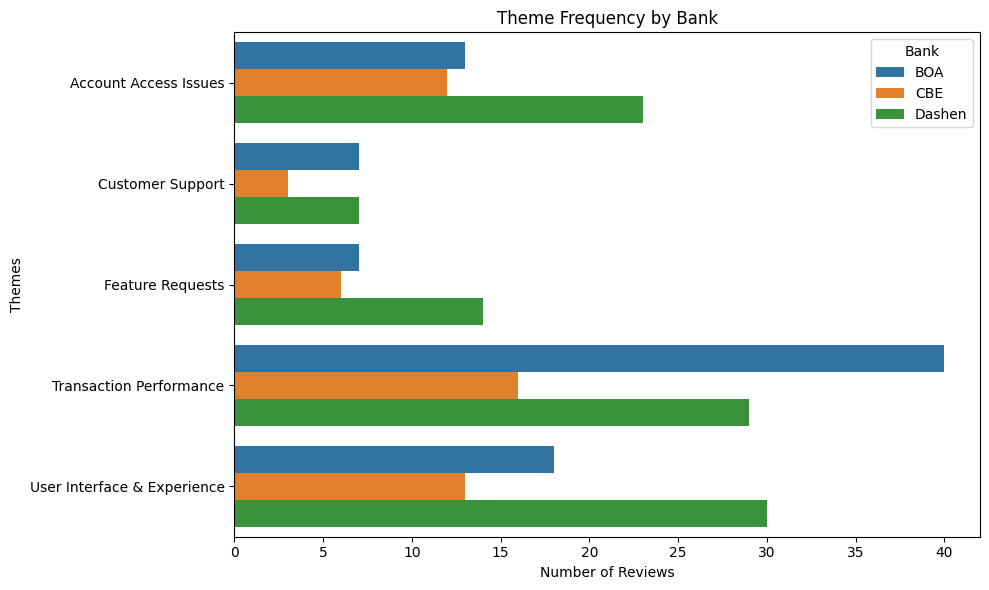

In [39]:
#Plot: Horizontal bar plot per bank of thematic analysis
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(data=theme_counts, x='count', y='themes_list', hue='bank')
plt.title('Theme Frequency by Bank')
plt.xlabel('Number of Reviews')
plt.ylabel('Themes')
plt.legend(title='Bank')
plt.tight_layout()
plt.savefig('themes_by_bank.png')
plt.show()


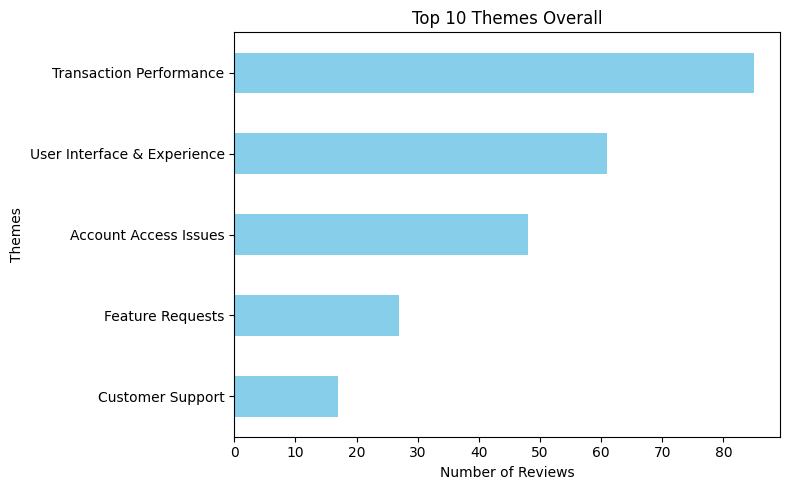

In [40]:
# Top themes overall
top_themes = df_exploded['themes_list'].value_counts().head(10)
top_themes.plot(kind='barh', figsize=(8,5), color='skyblue')
plt.title('Top 10 Themes Overall')
plt.xlabel('Number of Reviews')
plt.ylabel('Themes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('top_themes.png')
plt.show()